In [2]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
import glob
import PIL

# AUTOTUNE = tf.data.AUTOTUNE

In [3]:
model = tf.keras.models.load_model('classificatio_model.h5')

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 1,540,258
Trainable params: 1,528,126
Non-trainable params: 12,132
______________________________________________

In [5]:
RES = 32


In [11]:
# 사용안함
# 데이터 셋 호출 
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=False,
    image_size=(RES, RES),
    # batch_size=N_BATCH
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    # batch_size=N_BATCH
)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


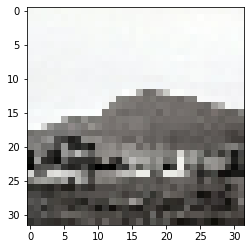

In [18]:
# 사용안함
# train_ds.shape
for image, label in train_ds.take(1):
    pass

plt.imshow(image[0].numpy().astype('uint8'))
# image[0].shape

In [6]:
folder_list = os.listdir('seg_train/seg_train')
folder_list

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [24]:
# image_list = glob.glob(folder_list + '*.png')
map = pd.DataFrame(columns=['image_path', '0', '1', '2', '3', '4', '5', '6' , '7', '8', '9'])


for folder in folder_list:
    
    images_list = glob.glob('seg_train/seg_train/' + folder + '/*.jpg')
    # print(len(images))
    
    for image_path in images_list:
        # print(type(image))
        # print(images)
        # img = tf.io.decode_image(image_path)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(RES, RES))
        # img = tf.image.decode_jpeg(image_path)
        # img = tf.image.resize(img, (RES, RES))
        # img = tf.keras.preprocessing.resize(img)
        # print(img.shape)
        img_tensor = tf.keras.preprocessing.image.img_to_array(img)
        # print(img_tensor.shape)
        # img_tensor = img_tensor[tf.newaxis, ...]
        pred = model.predict(img_tensor[tf.newaxis, ...])
        
        map = map.append({'image_path' : image_path, 
                    '0' : pred[0][0],
                    '1' : pred[0][1], 
                    '2' : pred[0][2], 
                    '3' : pred[0][3], 
                    '4' : pred[0][4], 
                    '5' : pred[0][5], 
                    '6' : pred[0][6], 
                    '7' : pred[0][7], 
                    '8' : pred[0][8], 
                    '9' : pred[0][9]}, ignore_index=True)
        
        
map
        
        



,image_path,0,1,2,3,4,5,6,7,8,9
0,seg_train/seg_train/buildings\0.jpg,9.999683e-01,1.361854e-06,6.906179e-06,1.775450e-05,4.200803e-06,1.492561e-06,8.305454e-21,5.239029e-19,1.054238e-21,9.000374e-19
1,seg_train/seg_train/buildings\10006.jpg,9.997237e-01,7.941216e-06,3.076276e-05,2.037189e-04,1.594497e-05,1.781594e-05,3.137069e-17,9.990489e-16,3.887617e-18,1.921403e-15
2,seg_train/seg_train/buildings\1001.jpg,9.995487e-01,5.398376e-05,6.930529e-05,6.225931e-05,2.628215e-05,2.392603e-04,2.840343e-15,1.261507e-13,7.750182e-16,1.387039e-13
3,seg_train/seg_train/buildings\10014.jpg,9.234645e-04,7.934677e-05,6.307434e-03,9.915576e-01,1.058316e-03,7.389826e-05,2.075920e-10,1.075287e-09,2.879689e-11,1.289411e-10
4,seg_train/seg_train/buildings\10018.jpg,9.999956e-01,5.473261e-07,1.974468e-06,1.080802e-06,5.500685e-07,1.098406e-07,5.761624e-24,1.374467e-21,6.609033e-25,1.484951e-21
...,...,...,...,...,...,...,...,...,...,...,...
14029,seg_train/seg_train/street\9961.jpg,4.800708e-07,1.213376e-05,1.236870e-06,9.785554e-09,1.278704e-07,9.999861e-01,3.701496e-21,1.838479e-21,2.463993e-25,6.507733e-22
14030,seg_train/seg_train/street\9967.jpg,1.079406e-06,4.788884e-05,2.727447e-06,4.970615e-08,7.199447e-08,9.999481e-01,4.822676e-20,7.515236e-20,2.608322e-23,1.128402e-20
14031,seg_train/seg_train/street\9978.jpg,3.327463e-05,4.222116e-04,4.214876e-05,2.131288e-06,6.188242e-06,9.994940e-01,3.029379e-15,1.596870e-15,1.416129e-17,1.507383e-15
14032,seg_train/seg_train/street\9989.jpg,4.436808e-07,4.214704e-06,1.745789e-07,9.935647e-10,1.214095e-08,9.999952e-01,1.840207e-22,4.396410e-22,5.151496e-26,2.647350e-23


In [25]:
map.to_csv('map.csv')